In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/requests_ntlm/requests_ntlm.py:5: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release of cryptography. Please upgrade your Python.
  from cryptography import x509
/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/__init__.py:91: DeprecationWarning: Using Qiskit with Python 3.5 is deprecated as of the 0.12.0 release. Support for running Qiskit with Python 3.5 will be removed at the Python 3.5 EoL on 09/13/2020.
  "Python 3.5 EoL on 09/13/2020.", DeprecationWarning)


ここでは、基底状態のエネルギー推定に似た問題を解くために、単純な単一クォビット変分法を使用します。具体的には、ランダムな確率ベクトル x⃗ が与えられ、それが x⃗ に近い確率分布を出力するような単一クォビット変分法のパラメータ化を決定したいと考えています (ここで、近さは2つの確率ベクトル間のマンハッタン距離で定義されます)。

まず、pythonでランダム確率ベクトルを作成します。

In [18]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)
print(target_distr)

[0.51357006 0.48642994]


続いて、単一のU3変分形のパラメータを引数にとり、対応する量子回路を返す関数を作成します。

In [19]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

ここでは、変分形式のパラメータのリストを入力として取り、それらのパラメータに関連するコストを返す目的関数を指定します。

In [20]:
from qiskit import Aer, execute
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

最後に、COBYLAオプティマイザのインスタンスを作成し、アルゴリズムを実行します。実行するたびに出力が変化することに注意してください。また、近いうちは、得られた分布が目標分布と完全に一致しないことがありますが、ショット数を増やすことで、出力の精度が上がります。

In [21]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  


Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.523, 0.477]
Output Error (Manhattan Distance): 0.009059881261160863
Parameters Found: [1.53486351 1.29733142 0.73143317]


すでに議論されているように、多項式パラメータ化された変分形は、任意の状態への変換を生成することができません。変分形式は、この制限にどのように対処するかによって、2つのカテゴリに分けることができます。最初のカテゴリの変分形式は、可能な出力状態のセットを制限するために、ドメインまたはアプリケーション固有の知識を使用します。第2のアプローチは、事前のドメインまたはアプリケーション固有の知識なしでヒューリスティック回路を使用します。

第 1 のカテゴリーの変分形式は、必要とされる可能性のある変換のセットを制限するために、問題領域の特性を利用します。例えば、分子の基底状態エネルギーを計算する場合、系内の粒子数は事前に知られている。したがって、正しい粒子数の開始状態が使用されている場合、変分形式を粒子保存変換のみを生成するように制限することで、新しい変換部分空間にまたがるために必要なパラメータの数を大幅に削減することができます。実際、Coupled-Cluster理論からの同様の情報を利用することで、変分形式UCCSDは、Hartree Fock状態から出発したときの分子基底状態のエネルギー推定のために非常に正確な結果を得ることができる。領域固有の知識を利用するもう一つの例として、実際の量子ハードウェア上で実現可能な回路のセットを考えることが挙げられます。超伝導量子ビットをベースにした量子コンピュータは、量子ビットの接続性が限られています。つまり、任意の量子ビットペアに（スワップゲートを挿入せずに）2ビットゲートを実装することはできません。そのため、特定の量子コンピュータアーキテクチャのために、回路が特定の量子デバイスのネイティブに利用可能な接続性とゲートを最大限に利用できるように特別に調整された変分形が構築されてきました。このような変分形は、2017年にIBM量子コンピュータ上でBeH 2ほどの大きさの分子の基底状態エネルギーの推定のためのVQEの実装に成功するために使用されました[4]。

第二のアプローチでは、ゲートは、広い範囲の状態で良好な近似が得られるように層状になっています。Qiskit Aquaは、このような3つの変分形式をサポートしています。RyRz、Ry、SwapRzです（最初の2つについてのみ説明します）。これらの変分形はすべて、ユーザーが指定した複数の設定を受け入れることができます。3つの重要な設定は、系内のクビット数、深さの設定、エンタングルメントの設定です。可変形の1つの層は、シングルクビットの回転とCXゲートの特定のパターンを指定します。深さ設定は、変分形式がこのパターンを何回繰り返すかを指定します。深さの設定を大きくすることで、最適化されなければならないパラメータの数を増やす代償として、変分形が生成できる状態のセットが増えます。最後に，もつれの設定は，CXゲートの構成，そして暗黙のうちに数を選択します．例えば、もつれ設定が線形の場合、CXゲートは隣接するクビットペアに順番に適用されます（したがって、レイヤごとにn-1のCXゲートが追加されます）。絡み合い設定がフルの場合は、各層の各クビットペアにCXゲートが適用されます。entanglement="full "と "linear "に対応するRyRzの回路は、以下のコードスニペットを実行することで確認できます。

=============Linear Entanglement:=============


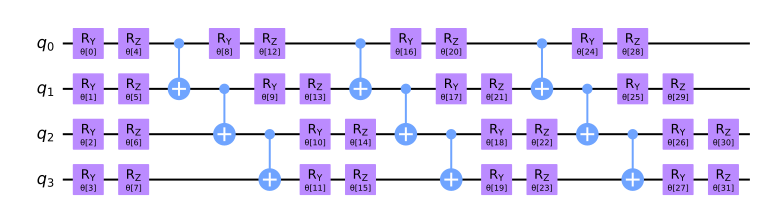


=============Full Entanglement:=============


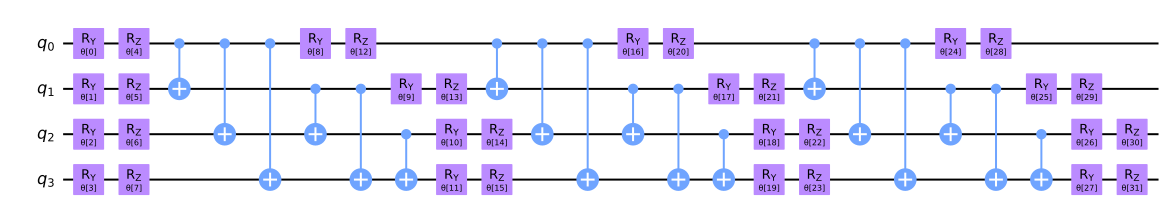

In [22]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    if entanglement == "linear":
        print("=============Linear Entanglement:=============")
    else:
        print("=============Full Entanglement:=============")
    # We initialize all parameters to 0 for this demonstration
    display(form.draw(fold=100,output="mpl"))
    print()

このセクションでは、プログラム的アプローチを用いたVQEの実装を説明します。Qiskit Aquaは宣言的な実装も可能にしますが、基礎となるアルゴリズムに関する情報が少なくなります。このコード、特にクビット演算子の準備は、Qiskit Tutorialsのリポジトリにあるコードに基づいています（2019年7月現在、https://github.com/Qiskit/qiskit-tutorials ）。

まず、以下のライブラリをインポートする必要があります。

In [2]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

様々な原子間距離におけるLiHの基底状態エネルギーの計算を実証した。各原子間距離で分子のドライバーを作らなければならない。この実験では、使用するqubitsの数を減らすために、コアを凍結させ、2つの未占有軌道を除去していることに注意してください。まず、原子間距離を取り、適切なクォビット演算子 H と、その演算子に関する他の情報を返す関数を定義する。

In [14]:
driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 1", unit=UnitsType.ANGSTROM, 
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print(molecule.num_orbitals)
print(molecule.nuclear_repulsion_energy)
print(molecule.num_alpha)
print(molecule.num_beta)

6
1.5875316327600002
2
2


In [26]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    print(remove_list, freeze_list)
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    print(remove_list, freeze_list)
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [47]:
qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(1)

print(qubitOp.num_qubits)
print(num_spin_orbitals)

[3, 4] [0]
[2, 3, 7, 8] [0, 6]
4
6


最初に、クビット演算子と古典的な正確な固有値ソルバーを使用して、正確な基底状態のエネルギーが計算されます。その後、初期状態｜ψ⟩が生成され、これをVQEインスタンスが最終的なアンサッツminθ(|ψ(θ)⟩)を生成するために使用します。各原子間距離における正確な結果とVQEの結果が格納されます。vqe.run(backend)['energy'] + shiftで与えられた結果は、minθ(⟨ψ(θ)|H|ψ(θ)⟩)と等価であり、最小値は必ずしもグローバル最小値ではないことに注意してください。

VQE(qubitOp, var_form, optimizer, 'matrix')でVQEインスタンスを初期化する場合、Hの期待値｜ψ(θ)⟩上のHは行列の乗算によって直接計算されます。しかし、実際の量子デバイスや、VQE(qubitOp, var_form, optimizer, 'paulis')を用いたqasm_simulatorのような真のシミュレータを使用する場合、期待値の計算はより複雑になります。ハミルトニアンはパウリ文字列の和として表現され、各パウリ項は使用されるマッピングで指定された通りにクォビットに作用します。それぞれのパウリ文字列は、対応する回路が｜ψ(θ)⟩ に対応する回路に付加されています。その後、これらの回路がそれぞれ実行され、すべての結果が｜ψ(θ)⟩ の H の期待値を決定するために使用されます。次の例では、VQE インスタンスを行列モードで初期化しているので、期待値は行列の乗算によって直接計算されます。

以下のコードスニペットは、実行して完了するまでに数分かかる場合があることに注意してください。

In [3]:
from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_valencia


In [16]:
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_athens


## Running VQE on a Noisy Simulator

ここでは、ノイズの多いシミュレータを用いてH2の基底状態エネルギーを計算し、誤差を軽減する。

まず、分子のハミルトニアンを表すクビット演算子を用意する。

In [12]:
driver = PySCFDriver(atom="N .0 .0 .0; N .0 .0 1.1", unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print(molecule.num_orbitals)
print(molecule.nuclear_repulsion_energy)
print(molecule.num_alpha)
print(molecule.num_beta)

10
23.572439395527272
7
7


In [5]:
#driver = PySCFDriver(atom='H .0 .0 -0.3625; H .0 .0 0.3625', unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
driver = PySCFDriver(atom="N .0 .0 .0; N .0 .0 1.1", unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
molecule = driver.run()
freeze_list = [0,1,2,3,4]
remove_list = [-3, -2]
repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
num_spin_orbitals -= len(freeze_list)
num_particles -= len(freeze_list)
ferOp = ferOp.fermion_mode_elimination(remove_list)
num_spin_orbitals -= len(remove_list)
qubitOp = ferOp.mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

In [6]:
qubitOp.num_qubits

4

In [7]:
num_particles

4

In [8]:
num_spin_orbitals

6

さて、IBMQプロバイダーからデバイス結合マップとノイズモデルをロードして量子インスタンスを作成し、エラー軽減を可能にします。

In [10]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_valencia")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model, 
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

In [10]:
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)

Exact Result: [18.16013187]


In [11]:
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping='parity'
)

var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity'
)

In [12]:
var_form.num_qubits

4

In [13]:
optimizer = SPSA(maxiter=100)
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping='parity'
)
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity'
)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue']+ molecule.nuclear_repulsion_energy)
print("VQE Result:", vqe_result)

VQE Result: 19.782014859699576


In [16]:
optimizer = SPSA(maxiter=100)
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping='parity'
)
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity'
)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)

In [22]:
%time vqe.run(quantum_instance)

Process Process-1596:
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/concurrent/futures/process.py", line 169, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/connection.py", l

In [64]:
distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SPSA(maxiter=100)
for dist in distances:
    driver = PySCFDriver(atom="N .0 .0 .0; N .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0,]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ molecule.nuclear_repulsion_energy)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

Process Process-322:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/concurrent/futures/process.py", line 181, in _process_worker
    result=r))
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/queues.py", line 341, in put
    obj = ForkingPickler.dumps(obj)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/multiprocessing/reduction.py", line 50, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/circuit/parameter.py", line 40, in __getnewargs__
    def __getnewargs__(self):


QiskitError: 'Keyboard interrupt in parallel_map.'

In [ ]:
distances = np.arange(1.0, 2.3, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SPSA(maxiter=100)
for dist in distances:
    driver = PySCFDriver(atom="N .0 .0 .0; N .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0,1,2,3]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + shift)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

Interatomic Distance: 1.0 VQE Result: -104.53431136440207 Exact Energy: [-107.42267128]
Interatomic Distance: 1.1 VQE Result: -104.74892857533423 Exact Energy: [-107.50091731]
Interatomic Distance: 1.2 VQE Result: -104.98880350257275 Exact Energy: [-107.49424001]
Interatomic Distance: 1.3 VQE Result: -105.21040448925685 Exact Energy: [-107.44348541]
Interatomic Distance: 1.4 VQE Result: -105.41973437142626 Exact Energy: [-107.37210769]
Interatomic Distance: 1.5 VQE Result: -105.46896604118054 Exact Energy: [-107.29331232]
Interatomic Distance: 1.6 VQE Result: -105.68440466247736 Exact Energy: [-107.21446642]
Interatomic Distance: 1.7 VQE Result: -105.54274482057095 Exact Energy: [-107.13974095]


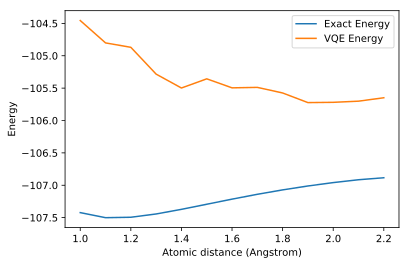

In [9]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()